In [1]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)

In [2]:
#Python-related imports
from datetime import datetime

#PyData imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function

#Module imports
from TruncatedNormal import *
from obs_and_flow import LowerBound

In [3]:
torch.manual_seed(0)
np.random.seed(0)

torch.set_printoptions(precision = 8)

In [4]:
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100.

prior_scale_factor = 0.25

#Parameter prior means
u_Q_ref_mean = 0.22
Q_mean = 0.001
a_MSA_mean = 0.5
K_DE_mean = 1000
K_UE_mean = 0.1
V_DE_ref_mean = 0.04
V_UE_ref_mean = 0.005
Ea_V_DE_mean = 40
Ea_V_UE_mean = 30
r_M_mean = 0.00016667
r_E_mean = 0.0002
r_L_mean = 0.0004
s_SOC_mean = 0.0002
s_DOC_mean = 0.0002
s_MBC_mean = 0.0002
s_EEC_mean = 0.0002

#SAWB-ECA theta truncated normal distribution parameter details in order of mean, sdev, lower, and upper.
u_Q_ref_details = torch.Tensor([u_Q_ref_mean, u_Q_ref_mean * prior_scale_factor, 0, 1])
Q_details = torch.Tensor([Q_mean, Q_mean * prior_scale_factor, 0, 0.1])
a_MSA_details = torch.Tensor([a_MSA_mean, a_MSA_mean * prior_scale_factor, 0, 1])
K_DE_details = torch.Tensor([K_DE_mean, K_DE_mean * prior_scale_factor, 0, 5000])
K_UE_details = torch.Tensor([K_UE_mean, K_UE_mean * prior_scale_factor, 0, 1])
V_DE_ref_details = torch.Tensor([V_DE_ref_mean, V_DE_ref_mean * prior_scale_factor, 0, 1])
V_UE_ref_details = torch.Tensor([V_UE_ref_mean, V_UE_ref_mean * prior_scale_factor, 0, 0.1])
Ea_V_DE_details = torch.Tensor([Ea_V_DE_mean, Ea_V_DE_mean * prior_scale_factor, 5, 80])
Ea_V_UE_details = torch.Tensor([Ea_V_UE_mean, Ea_V_UE_mean * prior_scale_factor, 5, 80])
r_M_details = torch.Tensor([r_M_mean, r_M_mean * prior_scale_factor, 0, 0.1])
r_E_details = torch.Tensor([r_E_mean, r_E_mean * prior_scale_factor, 0, 0.1])
r_L_details = torch.Tensor([r_L_mean, r_L_mean * prior_scale_factor, 0, 0.1])

#SAWB-ECA-SS diffusion matrix parameter distribution details
s_SOC_details = torch.Tensor([s_SOC_mean, s_SOC_mean * prior_scale_factor, 0, 0.1])
s_DOC_details = torch.Tensor([s_DOC_mean, s_DOC_mean * prior_scale_factor, 0, 0.1])
s_MBC_details = torch.Tensor([s_MBC_mean, s_MBC_mean * prior_scale_factor, 0, 0.1])
s_EEC_details = torch.Tensor([s_EEC_mean, s_EEC_mean * prior_scale_factor, 0, 0.1])

#SAWB-ECA theta rsample draws
u_Q_ref = TruncatedNormal(loc = u_Q_ref_details[0], scale = u_Q_ref_details[1], a = u_Q_ref_details[2], b = u_Q_ref_details[3]).rsample().cpu().detach().numpy()
Q = TruncatedNormal(loc = Q_details[0], scale = Q_details[1], a = Q_details[2], b = Q_details[3]).rsample().cpu().detach().numpy()
a_MSA = TruncatedNormal(loc = a_MSA_details[0], scale = a_MSA_details[1], a = a_MSA_details[2], b = a_MSA_details[3]).rsample().cpu().detach().numpy()
K_DE = TruncatedNormal(loc = K_DE_details[0], scale = K_DE_details[1], a = K_DE_details[2], b = K_DE_details[3]).rsample().cpu().detach().numpy()
K_UE = TruncatedNormal(loc = K_UE_details[0], scale = K_UE_details[1], a = K_UE_details[2], b = K_UE_details[3]).rsample().cpu().detach().numpy()
V_DE_ref = TruncatedNormal(loc = V_DE_ref_details[0], scale = V_DE_ref_details[1], a = V_DE_ref_details[2], b = V_DE_ref_details[3]).rsample().cpu().detach().numpy()
V_UE_ref = TruncatedNormal(loc = V_UE_ref_details[0], scale = V_UE_ref_details[1], a = V_UE_ref_details[2], b = V_UE_ref_details[3]).rsample().cpu().detach().numpy()
Ea_V_DE = TruncatedNormal(loc = Ea_V_DE_details[0], scale = Ea_V_DE_details[1], a = Ea_V_DE_details[2], b = Ea_V_DE_details[3]).rsample().cpu().detach().numpy()
Ea_V_UE = TruncatedNormal(loc = Ea_V_UE_details[0], scale = Ea_V_UE_details[1], a = Ea_V_UE_details[2], b = Ea_V_UE_details[3]).rsample().cpu().detach().numpy()
r_M = TruncatedNormal(loc = r_M_details[0], scale = r_M_details[1], a = r_M_details[2], b = r_M_details[3]).rsample().cpu().detach().numpy()
r_E = TruncatedNormal(loc = r_E_details[0], scale = r_E_details[1], a = r_E_details[2], b = r_E_details[3]).rsample().cpu().detach().numpy()
r_L = TruncatedNormal(loc = r_L_details[0], scale = r_L_details[1], a = r_L_details[2], b = r_L_details[3]).rsample().cpu().detach().numpy()
s_SOC = TruncatedNormal(loc = s_SOC_details[0], scale = s_SOC_details[1], a = s_SOC_details[2], b = s_SOC_details[3]).rsample().cpu().detach().numpy()
s_DOC = TruncatedNormal(loc = s_DOC_details[0], scale = s_DOC_details[1], a = s_DOC_details[2], b = s_DOC_details[3]).rsample().cpu().detach().numpy()
s_MBC = TruncatedNormal(loc = s_MBC_details[0], scale = s_MBC_details[1], a = s_MBC_details[2], b = s_MBC_details[3]).rsample().cpu().detach().numpy()
s_EEC = TruncatedNormal(loc = s_EEC_details[0], scale = s_EEC_details[1], a = s_EEC_details[2], b = s_EEC_details[3]).rsample().cpu().detach().numpy()

In [5]:
SAWB_ECA_SS_priors_dict = {'u_Q_ref': u_Q_ref_details, 'Q': Q_details, 'a_MSA': a_MSA_details, 'K_DE': K_DE_details, 'K_UE': K_UE_details, 'V_DE_ref': V_DE_ref_details, 'V_UE_ref': V_UE_ref_details, 'Ea_V_DE': Ea_V_DE_details, 'Ea_V_UE': Ea_V_UE_details, 'r_M': r_M_details, 'r_E': r_E_details, 'r_L': r_L_details, 's_SOC': s_SOC_details, 's_DOC': s_DOC_details, 's_MBC': s_MBC_details, 's_EEC': s_EEC_details}

In [6]:
SAWB_ECA_SS_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_DE': K_DE, 'K_UE': K_UE, 'V_DE_ref': V_DE_ref, 'V_UE_ref': V_UE_ref, 'Ea_V_DE': Ea_V_DE, 'Ea_V_UE': Ea_V_UE, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 's_SOC': s_SOC, 's_DOC': s_DOC, 's_MBC': s_MBC, 's_EEC': s_EEC}
print(SAWB_ECA_SS_params_dict)

{'u_Q_ref': array(0.2194861, dtype=float32), 'Q': array(0.00118326, dtype=float32), 'a_MSA': array(0.33124655, dtype=float32), 'K_DE': array(720.8212, dtype=float32), 'K_UE': array(0.08742235, dtype=float32), 'V_DE_ref': array(0.04342706, dtype=float32), 'V_UE_ref': array(0.00496901, dtype=float32), 'Ea_V_DE': array(52.615257, dtype=float32), 'Ea_V_UE': array(29.16851, dtype=float32), 'r_M': array(0.00018075, dtype=float32), 'r_E': array(0.00018059, dtype=float32), 'r_L': array(0.00037511, dtype=float32), 's_SOC': array(9.9633085e-05, dtype=float32), 's_DOC': array(0.00015207, dtype=float32), 's_MBC': array(0.0001729, dtype=float32), 's_EEC': array(0.00020232, dtype=float32)}


In [7]:
#Deterministic steady state solution functions.

def analytical_steady_state_init_CON(SOC_input, DOC_input, SCON_params_dict):
    '''
    Returns a vector of C pool values to initialize an SCON system corresponding to set of parameter values using the analytical steady state equations of the deterministic CON system.
    Vector elements are in order of S_0, D_0, M_0.
    Expected SCON_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, '[cs]_SOC': [cs]_SOC, '[cs]_DOC': [cs]_DOC, '[cs]_MBC': [cs]_MBC}
    '''
    D_0 = (DOC_input + SOC_input * SCON_params_dict['a_SD']) / (SCON_params_dict['u_M'] + SCON_params_dict['k_D_ref'] + SCON_params_dict['u_M'] * SCON_params_dict['a_M'] * (SCON_params_dict['a_MSC'] - 1 - SCON_params_dict['a_MSC'] * SCON_params_dict['a_SD']) - SCON_params_dict['a_DS'] * SCON_params_dict['k_D_ref'] * SCON_params_dict['a_SD'])
    S_0 = (SOC_input + D_0 * (SCON_params_dict['a_DS'] * SCON_params_dict['k_D_ref'] + SCON_params_dict['u_M'] * SCON_params_dict['a_M'] * SCON_params_dict['a_MSC'])) / SCON_params_dict['k_S_ref']
    M_0 = SCON_params_dict['u_M'] * D_0 / SCON_params_dict['k_M_ref']
    C_0_vector = torch.as_tensor([S_0, D_0, M_0])    
    #CO2_0 = SCON_params_dict['k_S_ref'] * S_0 * (1 - SCON_params_dict['a_SD']) + SCON_params_dict['k_D_ref'] * D_0 * (1 - SCON_params_dict['a_DS']) + SCON_params_dict['k_M_ref'] * M_0 * (1 - SCON_params_dict['a_M'])
    #C_0_vector = torch.as_tensor([S_0, D_0, M_0, CO2_0])
    return C_0_vector

def analytical_steady_state_init_AWB(SOC_input, DOC_input, SAWB_params_dict):
    '''
    Returns a vector of C pool values to initialize an SAWB system corresponding to set of parameter values using the analytical steady state equations of the deterministic CON system.
    Vector elements are in order of S_0, D_0, M_0, E_0.
    Expected SAWB_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_D': K_D, 'K_U': K_U, 'V_D_ref': V_D_ref, 'V_U_ref': V_U_ref, 'Ea_V_D': Ea_V_D, 'Ea_V_U': Ea_V_U, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, '[cs]_SOC': [cs]_SOC, '[cs]_DOC': [cs]_DOC, '[cs]_MBC': [cs]_MBC, '[cs]_EEC': [cs]_EEC}
    '''
    S_0 = -((SAWB_params_dict['K_D'] * SAWB_params_dict['r_L'] * (SOC_input * SAWB_params_dict['r_E'] * (-1 + SAWB_params_dict['u_Q_ref']) - SAWB_params_dict['a_MSA'] * DOC_input * SAWB_params_dict['r_M'] * SAWB_params_dict['u_Q_ref'] + SOC_input * SAWB_params_dict['r_M'] * (-1 + SAWB_params_dict['u_Q_ref'] - SAWB_params_dict['a_MSA'] * SAWB_params_dict['u_Q_ref']))) / (DOC_input * SAWB_params_dict['u_Q_ref'] * (-SAWB_params_dict['a_MSA'] * SAWB_params_dict['r_L'] * SAWB_params_dict['r_M'] + SAWB_params_dict['r_E'] * SAWB_params_dict['V_D_ref']) + SOC_input * (SAWB_params_dict['r_E'] * SAWB_params_dict['r_L'] * (-1 + SAWB_params_dict['u_Q_ref']) + SAWB_params_dict['r_L'] * SAWB_params_dict['r_M'] * (-1 + SAWB_params_dict['u_Q_ref'] - SAWB_params_dict['a_MSA'] * SAWB_params_dict['u_Q_ref']) + SAWB_params_dict['r_E'] * SAWB_params_dict['u_Q_ref'] * SAWB_params_dict['V_D_ref'])))
    D_0 = -((SAWB_params_dict['K_U'] * (SAWB_params_dict['r_E'] + SAWB_params_dict['r_M'])) / (SAWB_params_dict['r_E'] + SAWB_params_dict['r_M'] - SAWB_params_dict['u_Q_ref'] * SAWB_params_dict['V_U_ref']))
    M_0 = -((SOC_input + DOC_input) * SAWB_params_dict['u_Q_ref']) / ((SAWB_params_dict['r_E'] + SAWB_params_dict['r_M']) * (SAWB_params_dict['u_Q_ref'] - 1))
    E_0 = SAWB_params_dict['r_E'] * M_0 / SAWB_params_dict['r_L']
    C_0_vector = torch.as_tensor([S_0, D_0, M_0, E_0])    
    #E_0 = -((SAWB_params_dict['r_E'] * SAWB_params_dict['u_Q_ref'] * (SOC_input + DOC_input)) / (SAWB_params_dict['r_L'] * (SAWB_params_dict['r_E'] + SAWB_params_dict['r_M']) * (SAWB_params_dict['u_Q_ref'] - 1)))
    #CO2_0 = (1 - SAWB_params_dict['u_Q_ref']) * (SAWB_params_dict['V_U_ref'] * M_0 * D_0) / (SAWB_params_dict['K_U'] + D_0)
    #C_0_vector = torch.as_tensor([S_0, D_0, M_0, E_0, CO2_0])
    return C_0_vector

def analytical_steady_state_init_AWB_ECA(SOC_input, DOC_input, SAWB_ECA_params_dict):
    '''
    Returns a vector of C pool values to initialize an SAWB-ECA system corresponding to set of parameter values using the analytical steady state equations of the deterministic CON system.
    Vector elements are in order of S_0, D_0, M_0, E_0.
    Expected SAWB_ECA_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_DE': K_DE, 'K_UE': K_UE, 'V_DE_ref': V_DE_ref, 'V_UE_ref': V_UE_ref, 'Ea_V_DE': Ea_V_DE, 'Ea_V_UE': Ea_V_UE, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, '[cs]_SOC': [cs]_SOC, '[cs]_DOC': [cs]_DOC, '[cs]_MBC': [cs]_MBC, '[cs]_EEC': [cs]_EEC}
    '''
    S_0 = -(((-SAWB_ECA_params_dict['K_DE'] * SAWB_ECA_params_dict['r_L'] * (SAWB_ECA_params_dict['r_E'] + SAWB_ECA_params_dict['r_M']) * (-1 + SAWB_ECA_params_dict['u_Q_ref']) + (SOC_input + DOC_input) * SAWB_ECA_params_dict['r_E'] * SAWB_ECA_params_dict['u_Q_ref']) * (SAWB_ECA_params_dict['a_MSA'] * DOC_input * SAWB_ECA_params_dict['r_M'] * SAWB_ECA_params_dict['u_Q_ref'] + SOC_input * (SAWB_ECA_params_dict['r_E'] + SAWB_ECA_params_dict['r_M'] - SAWB_ECA_params_dict['r_E'] * SAWB_ECA_params_dict['u_Q_ref'] + (-1 + SAWB_ECA_params_dict['a_MSA']) * SAWB_ECA_params_dict['r_M']* SAWB_ECA_params_dict['u_Q_ref']))) / ((DOC_input + SOC_input) * SAWB_ECA_params_dict['r_E'] * (SAWB_ECA_params_dict['r_E'] + SAWB_ECA_params_dict['r_M']) * (-1 + SAWB_ECA_params_dict['u_Q_ref']) * SAWB_ECA_params_dict['u_Q_ref'] * SAWB_ECA_params_dict['V_DE_ref']))
    D_0 = -(SAWB_ECA_params_dict['K_UE'] * (SAWB_ECA_params_dict['r_E'] + SAWB_ECA_params_dict['r_M']) * (-1 + SAWB_ECA_params_dict['u_Q_ref']) - (SOC_input + DOC_input) * SAWB_ECA_params_dict['u_Q_ref']) / ((-1 + SAWB_ECA_params_dict['u_Q_ref']) * (SAWB_ECA_params_dict['r_E'] + SAWB_ECA_params_dict['r_M'] - SAWB_ECA_params_dict['u_Q_ref'] * SAWB_ECA_params_dict['V_UE_ref']))
    M_0 = -((SOC_input + DOC_input) * SAWB_ECA_params_dict['u_Q_ref']) / ((SAWB_ECA_params_dict['r_E'] + SAWB_ECA_params_dict['r_M']) * (SAWB_ECA_params_dict['u_Q_ref'] - 1))
    E_0 = SAWB_ECA_params_dict['r_E'] * M_0 / SAWB_ECA_params_dict['r_L']
    C_0_vector = torch.as_tensor([S_0, D_0, M_0, E_0])    
    #E_0 = -((SAWB_params_dict['r_E'] * SAWB_params_dict['u_Q_ref'] * (SOC_input + DOC_input)) / (SAWB_params_dict['r_L'] * (SAWB_params_dict['r_E'] + SAWB_params_dict['r_M']) * (SAWB_params_dict['u_Q_ref'] - 1)))
    #CO2_0 = (1 - SAWB_ECA_params_dict['u_Q_ref']) * SAWB_ECA_params_dict['V_UE_ref'] * M_0 * D_0 / (SAWB_ECA_params_dict['K_UE'] + M_0 + D_0)
    #C_0_vector = torch.as_tensor([S_0, D_0, M_0, E_0, CO2_0])
    return C_0_vector

In [8]:
SOC0, DOC0, MBC0, EEC0 = analytical_steady_state_init_AWB_ECA(0.001, 0.0001, SAWB_ECA_SS_params_dict)
print(SOC0, DOC0, MBC0, EEC0)

tensor(42.36412897, dtype=torch.float64) tensor(0.46746624, dtype=torch.float64) tensor(0.85605561, dtype=torch.float64) tensor(0.41212163, dtype=torch.float64)


In [9]:
dt = 0.01
t = 2000
x0_SAWB_ECA = [2 * SOC0, 4 * DOC0, 2 * MBC0, 4 * EEC0]
obs_every = 10
obs_error_scale = 0.1

In [10]:
# Save reparameterized prior and sampled theta
now = datetime.now()
sbm_model = 'SAWB-ECA-SS_CO2_trunc_short' + now.strftime('_%Y_%m_%d_%H_%M')
dir_path = 'generated_data/'
save_string = dir_path + f'{sbm_model}_sample_y_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')

#Save rsampled theta values.
torch.save(SAWB_ECA_SS_params_dict, save_string + '_rsample.pt')

#Save priors dict.
torch.save(SAWB_ECA_SS_priors_dict, save_string + '_hyperparams.pt')

#Save x0 mean.
torch.save(torch.tensor(x0_SAWB_ECA), save_string + '_x0_SAWB_ECA_tensor.pt')

In [11]:
keys = list(SAWB_ECA_SS_priors_dict.keys())
loc, scale, a, b = torch.tensor(list(zip(*(SAWB_ECA_SS_priors_dict[k] for k in keys))))

dist = TruncatedNormal(loc, scale, a, b)
x0 = torch.max(loc - 4*scale, a).detach()
x1 = torch.min(loc + 4*scale, b).detach()

num_pts = 10000
x = torch.from_numpy(np.linspace(x0, x1, num_pts))
pdf = torch.exp(dist.log_prob(x)).detach()

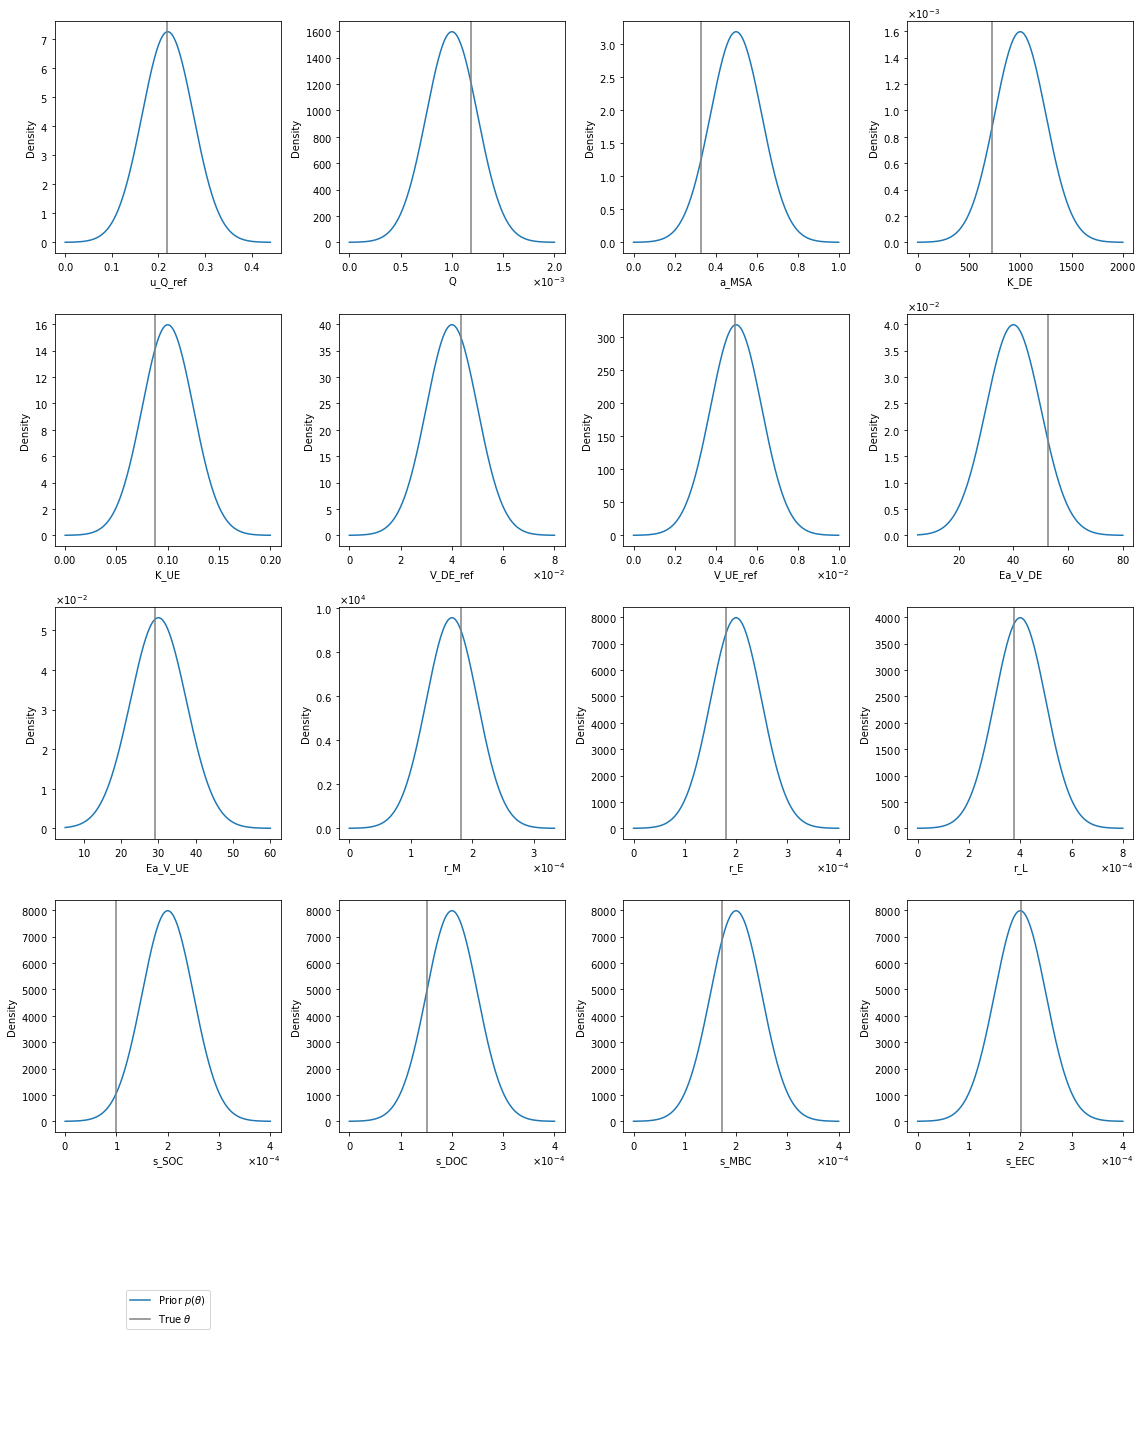

In [12]:
num_params = len(loc)
ncols = 4
nrows = int(num_params / ncols) + 1
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
axes = np.atleast_2d(axes)
param_index = 0
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if param_index < num_params:
            key = keys[param_index]
            ax.plot(x[:, param_index], pdf[:, param_index], label='Prior $p(\\theta)$')
            ax.axvline(SAWB_ECA_SS_params_dict[key], color='gray', label='True $\\theta$')
            ax.set_xlabel(key)
            ax.set_ylabel('Density')
            ax.ticklabel_format(style='sci', scilimits=(-2,4), axis='both', useMathText='True')
        elif param_index == num_params:
            handles, labels = axes[0, 0].get_legend_handles_labels()
            ax.legend(handles, labels, loc='center')
            ax.axis('off')
        else:
            fig.delaxes(axes[i, j])
        param_index += 1
plt.tight_layout()

In [13]:
def temp_func(t, TEMP_REF, TEMP_RISE):
    temp = TEMP_REF + (TEMP_RISE * t) / (80 * 24 * 365) + 10 * np.sin((2 * np.pi / 24) * t) + 10 * np.sin((2 * np.pi / (24 * 365)) * t)
    return temp

def I_S_func(t):
    return 0.001 + 0.0005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous SOC input function

def I_D_func(t):
    return 0.0001 + 0.00005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous DOC input function

def arrhenius_temp(parameter, temp, Ea, temp_ref):
    '''
    For a parameter with Arrhenius temperature dependence, returns the transformed parameter value.
    0.008314 is the gas constant. Temperatures are in K.
    '''
    decayed_parameter = parameter * np.exp(-Ea / 0.008314 * (1 / temp - 1 / temp_ref))
    return decayed_parameter

def linear_temp(parameter, temp, Q, temp_ref):
    '''
    For a parameter with linear temperature dependence, returns the transformed parameter value.
    Q is the slope of the temperature dependence and is a varying parameter.
    Temperatures are in K.
    '''
    modified_parameter = parameter - Q * (temp - temp_ref)
    return modified_parameter

In [14]:
#Generate data from SBM SDEs
#x in order of SOC, DOC, MBC (and EEC for AWB family models)

def alpha_SCON(x, SCON_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    k_S = arrhenius_temp(SCON_params_dict['k_S_ref'], current_temp, SCON_params_dict['Ea_S'], temp_ref)
    k_D = arrhenius_temp(SCON_params_dict['k_D_ref'], current_temp, SCON_params_dict['Ea_D'], temp_ref)
    k_M = arrhenius_temp(SCON_params_dict['k_M_ref'], current_temp, SCON_params_dict['Ea_M'], temp_ref)
    #Evolve drift.
    SOC = I_S + SCON_params_dict['a_DS'] * k_D * x[1] + SCON_params_dict['a_M'] * SCON_params_dict['a_MSC'] * k_M * x[2] - k_S * x[0]
    DOC = I_D + SCON_params_dict['a_SD'] * k_S * x[0] + SCON_params_dict['a_M'] * (1 - SCON_params_dict['a_MSC']) * k_M * x[2] - (SCON_params_dict['u_M'] + k_D) * x[1]
    MBC = SCON_params_dict['u_M'] * x[1] - k_M * x[2]
    return np.array([SOC, DOC, MBC])

def beta_SCON_C(x, SCON_C_params_dict):
    b11 = SCON_C_params_dict['c_SOC']
    b22 = SCON_C_params_dict['c_DOC']
    b33 = SCON_C_params_dict['c_MBC']
    return np.diag([b11, b22, b33])

def beta_SCON_SS(x, SCON_SS_params_dict):
    b11 = SCON_SS_params_dict['s_SOC'] * x[0]
    b22 = SCON_SS_params_dict['s_DOC'] * x[1]
    b33 = SCON_SS_params_dict['s_MBC'] * x[2]
    return np.diag([b11, b22, b33])

def alpha_SAWB(x, SAWB_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_params_dict['u_Q_ref'], current_temp, SAWB_params_dict['Q'], temp_ref)
    V_D = arrhenius_temp(SAWB_params_dict['V_D_ref'], current_temp, SAWB_params_dict['Ea_V_D'], temp_ref)
    V_U = arrhenius_temp(SAWB_params_dict['V_U_ref'], current_temp, SAWB_params_dict['Ea_V_U'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_params_dict['a_MSA'] * SAWB_params_dict['r_M'] * x[2] - ((V_D * x[3] * x[0]) / (SAWB_params_dict['K_D'] + x[0]))
    DOC = I_D + (1 - SAWB_params_dict['a_MSA']) * SAWB_params_dict['r_M'] * x[2] + ((V_D * x[3] * x[0]) / (SAWB_params_dict['K_D'] + x[0])) + SAWB_params_dict['r_L'] * x[3] - ((V_U * x[2] * x[1]) / (SAWB_params_dict['K_U'] + x[1]))
    MBC = (u_Q * (V_U * x[2] * x[1]) / (SAWB_params_dict['K_U'] + x[1])) - (SAWB_params_dict['r_M'] + SAWB_params_dict['r_E']) * x[2]
    EEC = SAWB_params_dict['r_E'] * x[2] - SAWB_params_dict['r_L'] * x[3]
    return np.array([SOC, DOC, MBC, EEC])

def beta_SAWB_C(x, SAWB_C_params_dict):
    b11 = SAWB_C_params_dict['c_SOC']
    b22 = SAWB_C_params_dict['c_DOC']
    b33 = SAWB_C_params_dict['c_MBC']
    b44 = SAWB_C_params_dict['c_EEC']
    return np.diag([b11, b22, b33, b44])

def beta_SAWB_SS(x, SAWB_SS_params_dict):
    b11 = SAWB_SS_params_dict['s_SOC'] * x[0]
    b22 = SAWB_SS_params_dict['s_DOC'] * x[1]
    b33 = SAWB_SS_params_dict['s_MBC'] * x[2]
    b44 = SAWB_SS_params_dict['s_EEC'] * x[3]
    return np.diag([b11, b22, b33, b44])

def alpha_SAWB_ECA(x, SAWB_ECA_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_ECA_params_dict['u_Q_ref'], current_temp, SAWB_ECA_params_dict['Q'], temp_ref)
    V_DE = arrhenius_temp(SAWB_ECA_params_dict['V_DE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_DE'], temp_ref)
    V_UE = arrhenius_temp(SAWB_ECA_params_dict['V_UE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_UE'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_ECA_params_dict['a_MSA'] * SAWB_ECA_params_dict['r_M'] * x[2] - ((V_DE * x[3] * x[0]) / (SAWB_ECA_params_dict['K_DE'] + x[3] + x[0]))
    DOC = I_D + (1 - SAWB_ECA_params_dict['a_MSA']) * SAWB_ECA_params_dict['r_M'] * x[2] + ((V_DE * x[3] * x[0]) / (SAWB_ECA_params_dict['K_DE'] + x[3] + x[0])) + SAWB_ECA_params_dict['r_L'] * x[3] - ((V_UE * x[2] * x[1]) / (SAWB_ECA_params_dict['K_UE'] + x[2] + x[1]))
    MBC = (u_Q * (V_UE * x[2] * x[1]) / (SAWB_ECA_params_dict['K_UE'] + x[2] + x[1])) - (SAWB_ECA_params_dict['r_M'] + SAWB_ECA_params_dict['r_E']) * x[2]
    EEC = SAWB_ECA_params_dict['r_E'] * x[2] - SAWB_ECA_params_dict['r_L'] * x[3]
    return np.array([SOC, DOC, MBC, EEC])

def beta_SAWB_ECA_C(x, SAWB_ECA_C_params_dict):
    b11 = SAWB_ECA_C_params_dict['c_SOC']
    b22 = SAWB_ECA_C_params_dict['c_DOC']
    b33 = SAWB_ECA_C_params_dict['c_MBC']
    b44 = SAWB_ECA_C_params_dict['c_EEC']
    return np.diag([b11, b22, b33, b44])

def beta_SAWB_ECA_SS(x, SAWB_ECA_SS_params_dict):
    b11 = SAWB_ECA_SS_params_dict['s_SOC'] * x[0]
    b22 = SAWB_ECA_SS_params_dict['s_DOC'] * x[1]
    b33 = SAWB_ECA_SS_params_dict['s_MBC'] * x[2]
    b44 = SAWB_ECA_SS_params_dict['s_EEC'] * x[3]
    return np.diag([b11, b22, b33, b44])

In [15]:
def get_CO2_CON_gen_y(x, SCON_params_dict, current_temp, TEMP_REF):
    state_dim = 3 #SCON has three state variables in SOC, DOC, and MBC.
    SOC, DOC, MBC =  np.array_split(x, state_dim, 0) #Partition SOC, DOC, and MBC values. Split based on final C_PATH dim, which specifies state variables and is also indexed as dim #2 in tensor.
    #Decay parameters are forced by temperature changes.    
    k_S = arrhenius_temp(SCON_params_dict['k_S_ref'], current_temp, SCON_params_dict['Ea_S'], TEMP_REF) #Apply vectorized temperature-dependent transformation to k_S_ref.
    k_D = arrhenius_temp(SCON_params_dict['k_D_ref'], current_temp, SCON_params_dict['Ea_D'], TEMP_REF) #Apply vectorized temperature-dependent transformation to k_D_ref.
    k_M = arrhenius_temp(SCON_params_dict['k_M_ref'], current_temp, SCON_params_dict['Ea_M'], TEMP_REF) #Apply vectorized temperature-dependent transformation to k_M_ref.
    CO2 = (k_S * SOC * (1 - SCON_params_dict['a_SD'])) + (k_D * DOC * (1 - SCON_params_dict['a_DS'])) + (k_M * MBC * (1 - SCON_params_dict['a_M']))
    return np.amax(CO2, 0)

def get_CO2_AWB_gen_y(x, SAWB_params_dict, current_temp, TEMP_REF):
    state_dim = 4 #SAWB and SAWB-ECA have four state variables in SOC, DOC, MBC, and EEC.
    SOC, DOC, MBC, EEC = np.array_split(x, state_dim, 0) #Partition SOC, DOC, MBC, EEC values. Split based on final C_PATH dim, which specifies state variables and is also indexed as dim #2 in tensor. 
    #Decay parameters are forced by temperature changes.    
    u_Q = linear_temp(SAWB_params_dict['u_Q_ref'], current_temp, SAWB_params_dict['Q'], TEMP_REF) #Apply linear temperature-dependence to u_Q.
    V_D = arrhenius_temp(SAWB_params_dict['V_D_ref'], current_temp, SAWB_params_dict['Ea_V_D'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_D.
    V_U = arrhenius_temp(SAWB_params_dict['V_U_ref'], current_temp, SAWB_params_dict['Ea_V_U'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_U.
    CO2 = (1 - u_Q) * (V_U * MBC * DOC) / (SAWB_params_dict['K_U'] + MBC + DOC)
    return np.amax(CO2, 0)

def get_CO2_AWB_ECA_gen_y(x, SAWB_ECA_params_dict, current_temp, TEMP_REF):
    state_dim = 4 #SAWB and SAWB-ECA have four state variables in SOC, DOC, MBC, and EEC.
    SOC, DOC, MBC, EEC = np.array_split(x, state_dim, 0) #Partition SOC, DOC, MBC, EEC values. Split based on final C_PATH dim, which specifies state variables and is also indexed as dim #2 in tensor. 
    #Decay parameters are forced by temperature changes.    
    u_Q = linear_temp(SAWB_ECA_params_dict['u_Q_ref'], current_temp, SAWB_ECA_params_dict['Q'], TEMP_REF) #Apply linear temperature-dependence to u_Q.
    V_DE = arrhenius_temp(SAWB_ECA_params_dict['V_DE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_DE'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_DE.
    V_UE = arrhenius_temp(SAWB_ECA_params_dict['V_UE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_UE'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_UE.
    CO2 = (1 - u_Q) * (V_UE * MBC * DOC) / (SAWB_ECA_params_dict['K_UE'] + MBC + DOC)
    return np.amax(CO2, 0)

In [16]:
def get_SBM_SDE_euler_maruyama_y(ALPHA, BETA, X0, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, TEMP_REF, TEMP_RISE, OBS_EVERY, OBS_ERROR_SCALE, lower_bound = 1e-5):
    state_dim = 0
    get_CO2_gen_y = None
    if ALPHA == alpha_SCON:
        state_dim = 3
        get_CO2_gen_y = get_CO2_CON_gen_y
    elif ALPHA == alpha_SAWB:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_gen_y
    elif ALPHA == alpha_SAWB_ECA:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_ECA_gen_y
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([state_dim, N])
    CO2 = np.zeros([1, N])
    X0_array = np.array(X0)
    X0_sample = np.random.normal(loc = X0_array, scale = OBS_ERROR_SCALE * X0_array) #Add noise to initial conditions of x.
    X0_sample[X0_sample < lower_bound] = lower_bound #Bound initial conditions above 0. 
    print('X0_sample = ', X0_sample)
    x[:, 0] = X0_sample
    CO2[:, 0] = get_CO2_gen_y(x[:, 0], THETA_DICT, TEMP_FUNC(0, TEMP_REF, TEMP_RISE), TEMP_REF)
    hour = 0
    for i in range(1, N):
        hour += DT
        I_S = I_S_FUNC(hour)
        #print('I_S', I_S)
        I_D = I_D_FUNC(hour)
        #print('I_D', I_D)
        current_temp = TEMP_FUNC(hour, TEMP_REF, TEMP_RISE)
        #print('current_temp', current_temp)
        #Take Euler-Maruyama step. Note: np.random.normal takes std while np.random.multivariate_normal takes cov.
        x[:, i] = np.random.multivariate_normal(mean = x[:, i - 1] + ALPHA(x[:, i - 1], THETA_DICT, I_S, I_D, current_temp, TEMP_REF, arrhenius_temp, linear_temp) * DT, cov = BETA(x[:, i - 1], THETA_DICT) * DT)
        x[:, i][x[:, i] < lower_bound] = lower_bound #Bound all x above 0.
        #print('x at i', x[:, i])
        CO2[:, i] = get_CO2_gen_y(x[:, i], THETA_DICT, current_temp, TEMP_REF) #Compute CO2.
    x_with_CO2 = np.concatenate((x, CO2), 0)
    x_with_CO2_for_y = x_with_CO2[:, 0::int(OBS_EVERY / DT)] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_with_CO2_for_y.mean(1)
    y = x_with_CO2_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_with_CO2_for_y.shape) #Introduce observation error based on mean state sizes to generate y.
    y[y < lower_bound] = lower_bound #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'y_std': obs_var_scale, 'x': x_with_CO2, 't_x': np.arange(0, T + DT, DT)} #Note: np.arange floating point imprecision can result in issues for generation of observation time arrays. Watch out for T = 2500.

def get_SBM_SDE_euler_maruyama_y_det(ALPHA, X0, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, TEMP_REF, TEMP_RISE, OBS_EVERY, OBS_ERROR_SCALE, lower_bound = 1e-5):
    state_dim = 0
    get_CO2_gen_y = None
    if ALPHA == alpha_SCON:
        state_dim = 3
        get_CO2_gen_y = get_CO2_CON_gen_y
    elif ALPHA == alpha_SAWB:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_gen_y
    elif ALPHA == alpha_SAWB_ECA:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_ECA_gen_y
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([state_dim, N])
    CO2 = np.zeros([1, N])
    X0_array = np.array(X0)
    X0_sample = np.random.normal(loc = X0_array, scale = OBS_ERROR_SCALE * X0_array) #Add noise to initial conditions of x.
    X0_sample[X0_sample < lower_bound] = lower_bound #Bound initial conditions above 0. 
    print('X0_sample = ', X0_sample)
    x[:, 0] = X0_sample
    CO2[:, 0] = get_CO2_gen_y(x[:, 0], THETA_DICT, TEMP_FUNC(0, TEMP_REF, TEMP_RISE), TEMP_REF) #Compute initial CO2.
    hour = 0
    for i in range(1, N):
        hour += DT
        I_S = I_S_FUNC(hour)
        #print('I_S', I_S)
        I_D = I_D_FUNC(hour)
        #print('I_D', I_D)
        current_temp = TEMP_FUNC(hour, TEMP_REF, TEMP_RISE)
        #print('current_temp', current_temp)
        #Take Euler.
        x[:, i] = x[:, i - 1] + ALPHA(x[:, i - 1], THETA_DICT, I_S, I_D, current_temp, TEMP_REF, arrhenius_temp, linear_temp) * DT
        x[:, i][x[:, i] < lower_bound] = lower_bound #Bound all x above 0.
        #print('x at i', x[:, i])
        CO2[:, i] = get_CO2_gen_y(x[:, i], THETA_DICT, current_temp, TEMP_REF) #Compute CO2. 
    x_with_CO2 = np.concatenate((x, CO2), 0)
    x_with_CO2_for_y = x_with_CO2[:, 0::int(OBS_EVERY / DT)] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_with_CO2_for_y.mean(1)
    y = x_with_CO2_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_with_CO2_for_y.shape) #Introduce observation error based on mean state sizes to generate y.
    y[y < lower_bound] = lower_bound #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'y_std': obs_var_scale, 'x': x_with_CO2, 't_x': np.arange(0, T + DT, DT)} #Note: np.arange floating point imprecision can result in issues for generation of observation time arrays. Watch out for T = 2500.

In [17]:
y_dict = get_SBM_SDE_euler_maruyama_y(alpha_SAWB_ECA, beta_SAWB_ECA_SS, x0_SAWB_ECA, t, dt, SAWB_ECA_SS_params_dict, I_S_func, I_D_func, temp_func, temp_ref, temp_rise, obs_every, obs_error_scale)

X0_sample =  [99.67476616  1.94468895  1.87968205  2.01789474]


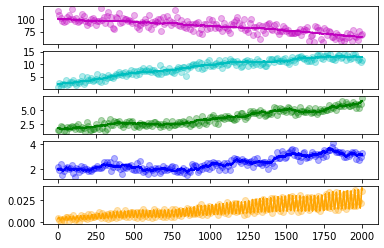

In [18]:
fig, axs = plt.subplots(5, sharex = True)
axs[0].plot(y_dict['t_x'], y_dict['x'][0, :], color = "m", label = 'SOC x')
axs[0].scatter(y_dict['t_y'], y_dict['y'][0, :], color = "m", alpha = 0.3, label = 'SOC y')
axs[1].plot(y_dict['t_x'], y_dict['x'][1, :], color = "c", label = 'DOC x')
axs[1].scatter(y_dict['t_y'], y_dict['y'][1, :], color = "c", alpha = 0.3, label = 'DOC y')
axs[2].plot(y_dict['t_x'], y_dict['x'][2, :], color = "g", label = 'MBC x')
axs[2].scatter(y_dict['t_y'], y_dict['y'][2, :], color = "g", alpha = 0.3, label = 'MBC y')
axs[3].plot(y_dict['t_x'], y_dict['x'][3, :], color = "b", label = 'EEC')
axs[3].scatter(y_dict['t_y'], y_dict['y'][3, :], color = "b", alpha = 0.3, label = 'EEC y')
axs[4].plot(y_dict['t_x'], y_dict['x'][4, :], color = "orange", label = 'CO2')
axs[4].scatter(y_dict['t_y'], y_dict['y'][4, :], color = "orange", alpha = 0.3, label = 'CO2 y')

In [27]:
df_y = pd.DataFrame(data = {'hour': y_dict['t_y'], 'SOC': y_dict['y'][0, :], 'DOC': y_dict['y'][1, :], 'MBC': y_dict['y'][2, :], 'EEC': y_dict['y'][3, :], 'CO2': y_dict['y'][4, :]})
print(np.min(df_y['SOC']))
print(np.min(df_y['DOC']))
print(np.min(df_y['MBC']))
print(np.min(df_y['EEC']))
print(np.min(df_y['CO2']))

54.352144790642875
0.7718406561090387
1.1889876387857226
1.3417846469164143
1e-05


In [20]:
print(df_y)

       hour         SOC        DOC       MBC       EEC       CO2
0       0.0  114.443774   0.771841  1.500683  2.156523  0.004557
1      10.0  107.214577   2.270840  1.561348  1.876220  0.002531
2      20.0  101.702180   0.938465  2.214600  2.361314  0.000100
3      30.0   95.273903   1.893117  2.051229  1.547335  0.003465
4      40.0   94.020249   2.023179  1.422116  1.804131  0.000884
..      ...         ...        ...       ...       ...       ...
196  1960.0   64.570917  13.024469  5.312702  2.838215  0.018446
197  1970.0   58.153354  11.696927  5.985302  3.195728  0.028851
198  1980.0   76.911077  11.936432  5.255158  2.760933  0.024210
199  1990.0   68.317040  10.648200  6.064825  2.971004  0.021796
200  2000.0   69.283278  11.715860  6.996203  3.310318  0.035788

[201 rows x 6 columns]


In [21]:
y_det_dict = get_SBM_SDE_euler_maruyama_y_det(alpha_SAWB_ECA, x0_SAWB_ECA, t, dt, SAWB_ECA_SS_params_dict, I_S_func, I_D_func, temp_func, temp_ref, temp_rise, obs_every, obs_error_scale)

X0_sample =  [76.33330474  1.77348011  1.69849359  1.68134221]


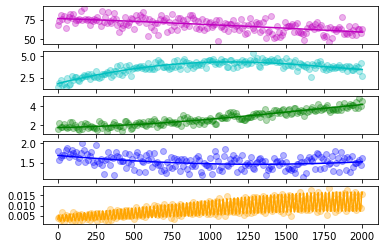

In [22]:
fig2, axs2 = plt.subplots(5, sharex = True)
axs2[0].plot(y_det_dict['t_x'], y_det_dict['x'][0, :], color = "m", label = 'SOC x')
axs2[0].scatter(y_det_dict['t_y'], y_det_dict['y'][0, :], color = "m", alpha = 0.3, label = 'SOC y')
axs2[1].plot(y_det_dict['t_x'], y_det_dict['x'][1, :], color = "c", label = 'DOC x')
axs2[1].scatter(y_det_dict['t_y'], y_det_dict['y'][1, :], color = "c", alpha = 0.3, label = 'DOC y')
axs2[2].plot(y_det_dict['t_x'], y_det_dict['x'][2, :], color = "g", label = 'MBC x')
axs2[2].scatter(y_det_dict['t_y'], y_det_dict['y'][2, :], color = "g", alpha = 0.3, label = 'MBC y')
axs2[3].plot(y_det_dict['t_x'], y_det_dict['x'][3, :], color = "b", label = 'EEC')
axs2[3].scatter(y_det_dict['t_y'], y_det_dict['y'][3, :], color = "b", alpha = 0.3, label = 'EEC y')
axs2[4].plot(y_det_dict['t_x'], y_det_dict['x'][4, :], color = "orange", label = 'CO2')
axs2[4].scatter(y_det_dict['t_y'], y_det_dict['y'][4, :], color = "orange", alpha = 0.3, label = 'CO2 y')

In [23]:
df_y_det = pd.DataFrame(data = {'hour': y_det_dict['t_y'], 'SOC': y_det_dict['y'][0, :], 'DOC': y_det_dict['y'][1, :], 'MBC': y_det_dict['y'][2, :], 'EEC': y_det_dict['y'][3, :], 'CO2': y_det_dict['y'][4, :]})

In [26]:
print(np.min(df_y_det['SOC']))
print(np.min(df_y_det['DOC']))
print(np.min(df_y_det['MBC']))
print(np.min(df_y_det['EEC']))
print(np.min(df_y_det['CO2']))

45.71729488051082
1.3587355843969213
1.225303312045304
1.1280906275863145
0.0017744048372679154


In [25]:
#Save observation data frames for deterministic and stochastic data.
df_y.to_csv(save_string + '.csv', index = False)
fig.savefig(save_string + '.png', dpi = 300)

save_string_det = dir_path + f'{sbm_model}_sample_det_y_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
df_y_det.to_csv(save_string_det + '.csv', index = False)
fig2.savefig(save_string_det + '.png', dpi = 300)